# This script demonstrates how to train a M²VAE with a split MNIST data set and evaluate the Hyperparameter

In [1]:
import vae_tools.sanity
import vae_tools.viz
import vae_tools.callbacks
import vae_tools.loader
from vae_tools.mmvae import MmVae, ReconstructionLoss
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
vae_tools.sanity.check()
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.datasets import mnist
import numpy as np
from scipy.stats import norm
# Set the seed for reproducible results
import vae_tools.sampling
vae_tools.sampling.set_seed(0)
# resize the notebook if desired
#vae_tools.nb_tools.notebook_resize()
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
import glob
import pickle

python version:  3.5.2
keras version: 2.2.4-tf
tensorflow version: 2.0.2
matplotlib uses:  module://ipykernel.pylab.backend_inline
No GPUs available


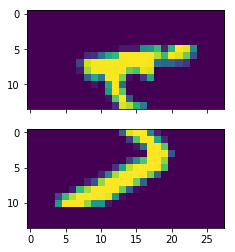

In [2]:

# Get the split MNIST digits
(x_train_a, x_train_b), (x_test_a, x_test_b), y_train, y_test = vae_tools.loader.mnist_split(flatten = True, split = 'hor')

# Show a split image

img_rows, img_cols = 28, 28

f, ax = plt.subplots(2,1,sharex=True)
ax[0].imshow(x_train_a[0,:].reshape(((int(img_rows/2), img_cols))))
ax[1].imshow(x_train_b[0,:].reshape(((int(img_rows/2), img_cols))))
plt.show()


In [3]:
dump_loc = '/mnt/ssd_pcie/mmvae_mnist_split/0/'
#dump_loc = '/mnt/ssd_pcie/mmvae_mnist_split/Backup_of_wrong_mutal_beta/1/'

df = pd.read_hdf(dump_loc + 'history.h5', key='df', mode='r+')
#df


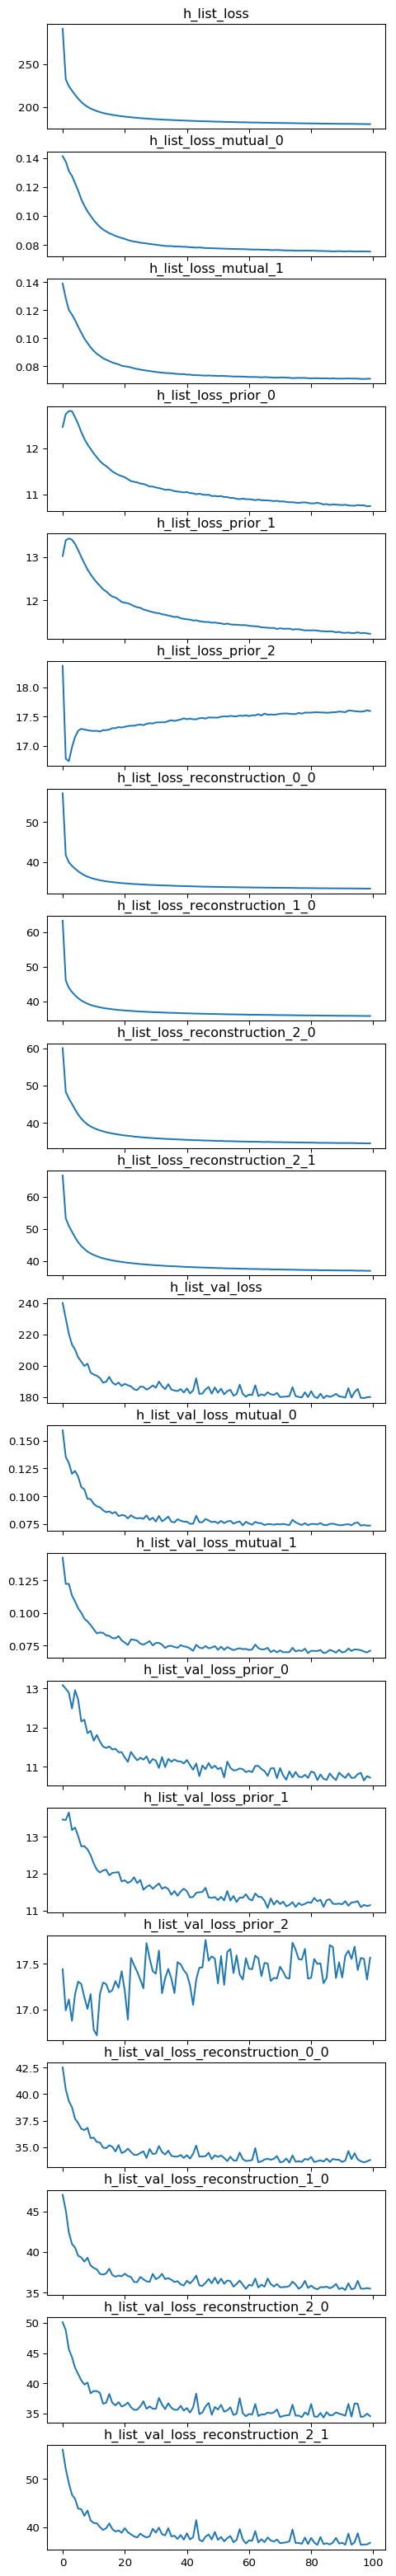

In [4]:
#df.columns
#df['h*'].columns
idx = 1
hist = tf.keras.callbacks.History()
hist.history = df[[c for c in df.columns if c[:6]=='h_list']].to_dict('records')[idx]
vae_tools.viz.plot_losses(hist, dpi=96, figsize_height_factor = .325)
plt.show()
#hist.history

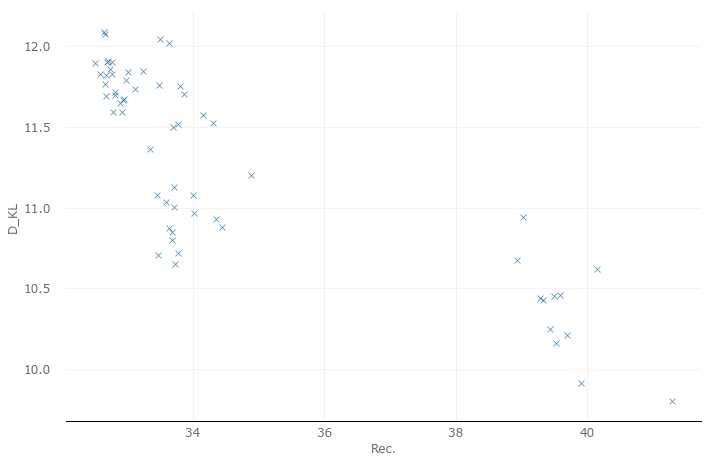

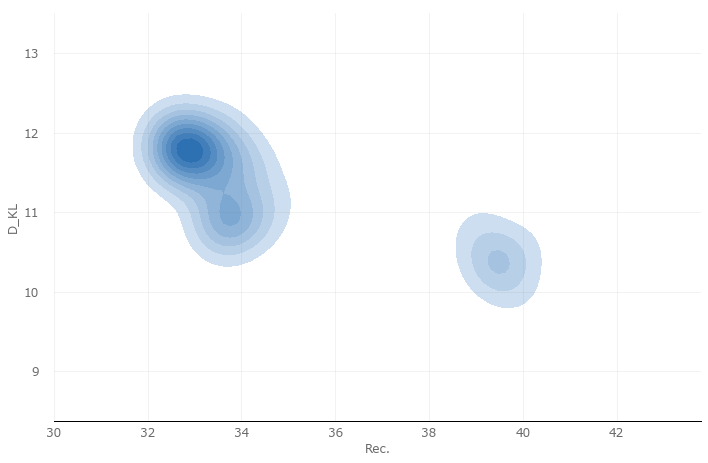

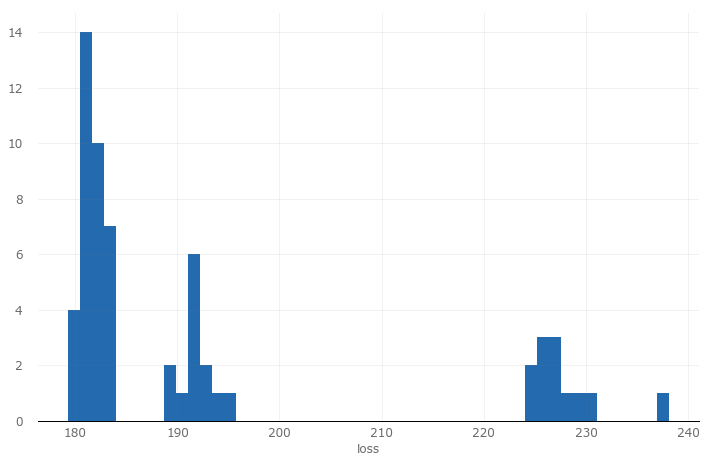

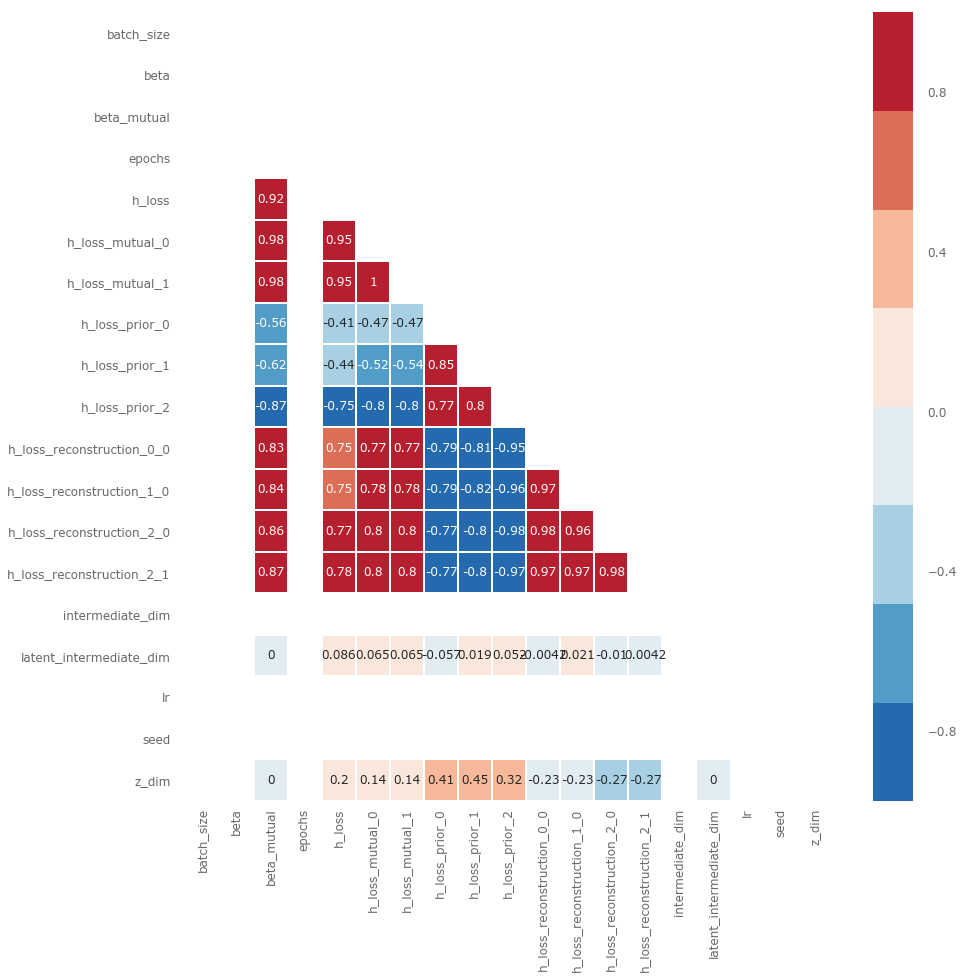

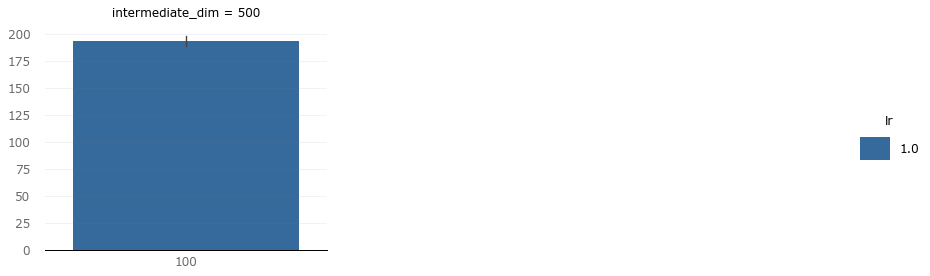

In [5]:
h_prefix = 'h_'
import astetik
%matplotlib inline

# a regression plot for two dimensions
astetik.regs(df, x=h_prefix + 'val_loss_reconstruction_0_0', y=h_prefix + 'val_loss_prior_0', x_label='Rec.', y_label='D_KL')
# up to two dimensional kernel density estimator
astetik.kde(df, x=h_prefix + 'val_loss_reconstruction_0_0', y=h_prefix + 'val_loss_prior_0', x_label='Rec.', y_label='D_KL')
# a simple histogram
astetik.hist(df, h_prefix + 'val_loss',bins=50, x_label='loss')
# correlation w/o validation
_df = df.drop(["activation","reconstruction_loss_metrics","optimizer","index"], axis=1)
_df = _df[[c for c in _df.columns if c[:5] != 'h_val']]
astetik.corr(_df, color_grades=5, style='astetik', annot=True)
# a four dimensional bar grid
astetik.bargrid(df, x='batch_size', y=h_prefix + 'val_loss', hue='lr', col='intermediate_dim',  col_wrap=3)



## Predict the visual data into the latent space using the trained encoder networks

In [6]:
# Get the models and predict all data
def predict(model_path, x_train = None, x_test = None):
    num_models = 2
    model_enc, _ = vae_tools.vae.GenericVae.load_model_powerset(model_path, num_models)
    model_enc_a, model_enc_b, model_enc_ab = model_enc[0], model_enc[1], model_enc[2]
    z_train, z_test = None, None
    if x_train is not None:
        z_train_ab = model_enc_ab.predict(x_train)
        z_train_a = model_enc_a.predict(x_train[0])
        z_train_b = model_enc_b.predict(x_train[1])
        z_train = (z_train_a, z_train_b, z_train_ab)
    if x_test is not None:
        z_test_ab = model_enc_ab.predict(x_test)
        z_test_a = model_enc_a.predict(x_test[0])
        z_test_b = model_enc_b.predict(x_test[1])
        z_test = (z_test_a, z_test_b, z_test_ab)
    # Cleanup
    for m in model_enc:
        del m
    tf.keras.backend.clear_session()
    return z_train, z_test


z_train_mean, z_test_mean = predict(dump_loc + 'enc_mean_' + str(idx) + '_ab_', x_train = [x_train_a, x_train_b], x_test = [x_test_a, x_test_b])
z_train_logvar, z_test_logvar = predict(dump_loc + 'enc_logvar_' + str(idx) + '_ab_', x_train = [x_train_a, x_train_b], x_test = [x_test_a, x_test_b])

z_train_a, z_train_b, z_train_ab = z_train_mean[0], z_train_mean[1], z_train_mean[2]
z_test_a, z_test_b, z_test_ab = z_test_mean[0], z_test_mean[1], z_test_mean[2]

z_train_logvar_a, z_train_logvar_b, z_train_logvar_ab = z_train_logvar[0], z_train_mean[1], z_train_logvar[2]
z_test_logvar_a, z_test_logvar_b, z_test_logvar_ab = z_test_logvar[0], z_test_logvar[1], z_test_logvar[2]


Loaded model /mnt/ssd_pcie/mmvae_mnist_split/4/enc_mean_1_ab_10 from disk
Loaded model /mnt/ssd_pcie/mmvae_mnist_split/4/enc_mean_1_ab_01 from disk
Loaded model /mnt/ssd_pcie/mmvae_mnist_split/4/enc_mean_1_ab_11 from disk
Loaded model /mnt/ssd_pcie/mmvae_mnist_split/4/enc_logvar_1_ab_10 from disk
Loaded model /mnt/ssd_pcie/mmvae_mnist_split/4/enc_logvar_1_ab_01 from disk
Loaded model /mnt/ssd_pcie/mmvae_mnist_split/4/enc_logvar_1_ab_11 from disk


## Train a naive Bayesian Classifier on the latent space of the encoder networks

In [7]:
def eval_bayes_classifier(z_train, z_test, y_train, y_test, verbose = False):
    from sklearn.naive_bayes import GaussianNB
    gnb = GaussianNB().fit(z_train, y_train)
    y_pred_ab = gnb.predict(z_test['z_test_ab'])
    y_pred_a = gnb.predict(z_test['z_test_a'])
    y_pred_b = gnb.predict(z_test['z_test_b'])
    if verbose:
        print("Test on %d points." %(y_test.shape[0]))
        print("mislabeled in ab : %d" % ((y_test != y_pred_ab).sum()))
        print("mislabeled in a  : %d" % ((y_test != y_pred_a).sum()))
        print("mislabeled in b  : %d" % ((y_test != y_pred_b).sum()))
    return y_pred_ab, y_pred_a, y_pred_b

z_train_all = {'z_test_ab': z_test_ab, 'z_test_a': z_test_a, 'z_test_b': z_test_b}

print("")
print("Trained on ab")
y_pred_ab_ab, y_pred_ab_a, y_pred_ab_b = eval_bayes_classifier(z_train_ab,
                      z_train_all,
                      y_train,
                      y_test,
                      True)

print("")
print("Trained on a")
y_pred_a_ab, y_pred_a_a, y_pred_a_b = eval_bayes_classifier(z_train_a,
                      z_train_all,
                      y_train,
                      y_test,
                      True)

print("")
print("Trained on b")
y_pred_b_ab, y_pred_b_a, y_pred_b_b = eval_bayes_classifier(z_train_b,
                      z_train_all,
                      y_train,
                      y_test,
                      True)



Trained on ab
Test on 10000 points.
mislabeled in ab : 1169
mislabeled in a  : 1983
mislabeled in b  : 2155

Trained on a
Test on 10000 points.
mislabeled in ab : 7544
mislabeled in a  : 1888
mislabeled in b  : 7942

Trained on b
Test on 10000 points.
mislabeled in ab : 8492
mislabeled in a  : 8770
mislabeled in b  : 2150


## KL and JS Losses

In [8]:
def rel_bar_plot(metric, label, prediction, min, max, bins, ax, wlabel='wrong', clabel='correct'):
    ''' Plot relative bar chart with correct and wrong classifications

    :param metric: 1D array with a metric for each sample
    :param label: 1D array with ground truth label for each sample
    :param prediction: 1D array with predicted label for each sample
    :param min: scalar minimum value of histogram
    :param max: scalar maximum value of histogram
    :param bins: number of bins
    :param ax: axis for plotting
    :param wlabel: string label for correct classified samples
    :param clabel: string label for wrong classified samples
    '''
    mw = metric[(label != prediction)]
    mc = metric[(label == prediction)]
    h_cw, edges = np.histogram(metric, bins, range=(min, max))
    h_c, edges = np.histogram(mc, bins, range=(min, max))
    h_w, edges = np.histogram(mw, bins, range=(min, max))

    # Format the values
    skip = edges[1]-edges[0]
    barWidth = skip*0.9
    x = [r+skip/2. for r in edges[:-1]]
    h_c = h_c / h_cw
    h_w = h_w / h_cw

    #raw_data = {'correct': h_c, 'wrong': h_w}
    #df = pd.DataFrame(raw_data)
    ax.bar(x, h_w, color='#f9bc86', edgecolor='white', width=barWidth, label=wlabel)
    ax.bar(x, h_c, bottom=h_w, color='#b5ffb9', edgecolor='white', width=barWidth, label=clabel)
    ax.set_xlim((min, max))

### KL

In [9]:
kl_ab_ab = vae_tools.metrics.kl_sym_loss(z_test_ab, z_test_ab, z_test_logvar_ab, z_test_logvar_a)
kl_ab_a = vae_tools.metrics.kl_sym_loss(z_test_ab, z_test_a, z_test_logvar_ab, z_test_logvar_a)
kl_ab_b = vae_tools.metrics.kl_sym_loss(z_test_ab, z_test_b, z_test_logvar_ab, z_test_logvar_b)
kl_a_b = vae_tools.metrics.kl_sym_loss(z_test_a, z_test_b, z_test_logvar_a, z_test_logvar_b)

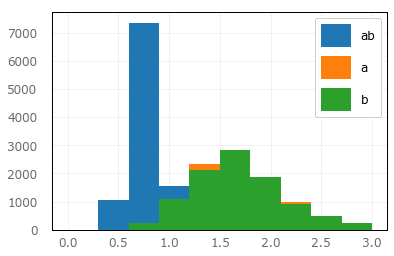

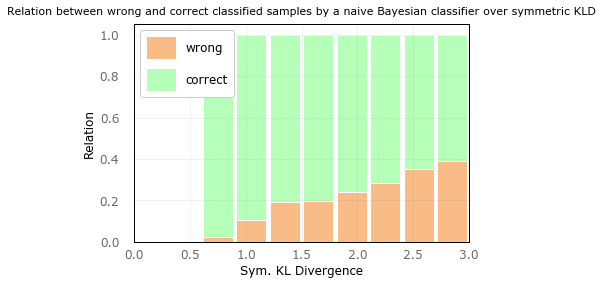

In [10]:
min = 0.
max = 3.
bins = 10
yx = plt.hist(kl_ab_ab.mean(axis=-1), bins, range=(min, max), label='ab')
yx_c = plt.hist(kl_ab_a.mean(axis=-1), bins, range=(min, max), label='a')
yx_w = plt.hist(kl_ab_b.mean(axis=-1), bins, range=(min, max), label='b')
plt.legend(loc='upper right')
plt.show()


_, ax = plt.subplots(1,1)
rel_bar_plot(kl_ab_b.mean(axis=-1), y_test, y_pred_ab_b, .0, 3., 10, ax)
ax.legend(loc='upper left')
ax.set_xlabel('Sym. KL Divergence')
ax.set_ylabel('Relation')
ax.set_title('Relation between wrong and correct classified samples by a naive Bayesian classifier over symmetric KLD')
plt.show()


### JS

In [11]:
loc = dump_loc + 'jsd_' + str(idx) + '_ab.p'
js = pickle.load( open( loc, "rb" ) )

#print(js)

# js structure:
# js = {'test_ab_vs_ab': js_d_ab,
#               'test_ab_vs_a': js_d_ab_a,
#               'test_ab_vs_b': js_d_ab_b,
#               'test_b_vs_a': js_d_b_a,
#               'train_ab_vs_ab': js_d_ab_train,
#               'train_ab_vs_a': js_d_ab_a_train,
#               'train_ab_vs_b': js_d_ab_b_train,
#               'train_b_vs_a': js_d_b_a_train}

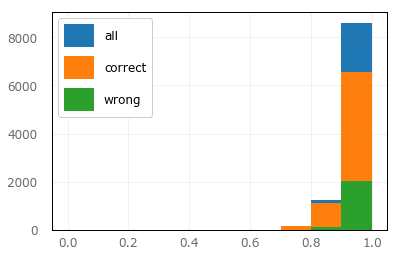

In [12]:
mw = js['test_ab_vs_b'][(y_test != y_pred_ab_b)]
mc = js['test_ab_vs_b'][(y_test == y_pred_ab_b)]
yx = plt.hist(js['test_ab_vs_b'], range=(.0, 1.), label='all')
yx_c = plt.hist(mc, range=(.0, 1.), label='correct')
yx_w = plt.hist(mw, range=(.0, 1.), label='wrong')
plt.legend(loc='upper left')
plt.show()

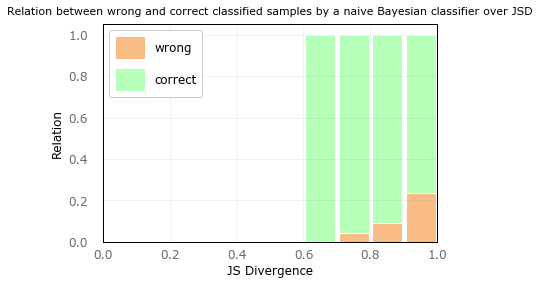

In [13]:
f, ax = plt.subplots()
rel_bar_plot(js['test_ab_vs_b'], y_test, y_pred_ab_b, 0.0, 1., 10, ax)
plt.legend(loc='upper left')
ax.set_xlim((0., 1.))
ax.set_xlabel('JS Divergence')
ax.set_ylabel('Relation')
plt.title('Relation between wrong and correct classified samples by a naive Bayesian classifier over JSD')
plt.show()

## Load the JSD and average it over all samples

In [14]:
prefix = 'jsd_'
jsd = None
for idx in df['index']:
    loc = dump_loc + 'jsd_' + str(idx) + '_ab.p'
    data = pickle.load( open( loc, "rb" ) )
    if jsd is None:
        jsd = {}
        for k in data.keys():
            jsd[prefix + k] = []
    for k in data.keys():
        #print(np.mean(js[k]))
        jsd[prefix + k].append(np.mean(data[k]))
# Add the JSD to the pandas data frame
df_jsd = pd.DataFrame(jsd, columns=jsd.keys())

## Load the GNB classifications and calculate the precision

In [15]:
#_df = df

gnb = None
prefix = 'gnb_prec_'
denom = len(y_test)
for idx in df['index']:
    loc = dump_loc + 'bayes_classifier_' + str(idx) + '.p'
    data = pickle.load( open( loc, "rb" ) )
    if gnb is None:
        gnb = {}
        for k in data.keys():
            gnb[prefix + k] = []
    for k in data.keys():
        #print(np.mean(js[k]))
        gnb[prefix + k].append(np.sum((data[k] == y_test))/denom)
# Add the JSD to the pandas data frame
df_gnb = pd.DataFrame(gnb, columns=gnb.keys())



## Show the correlation matrix

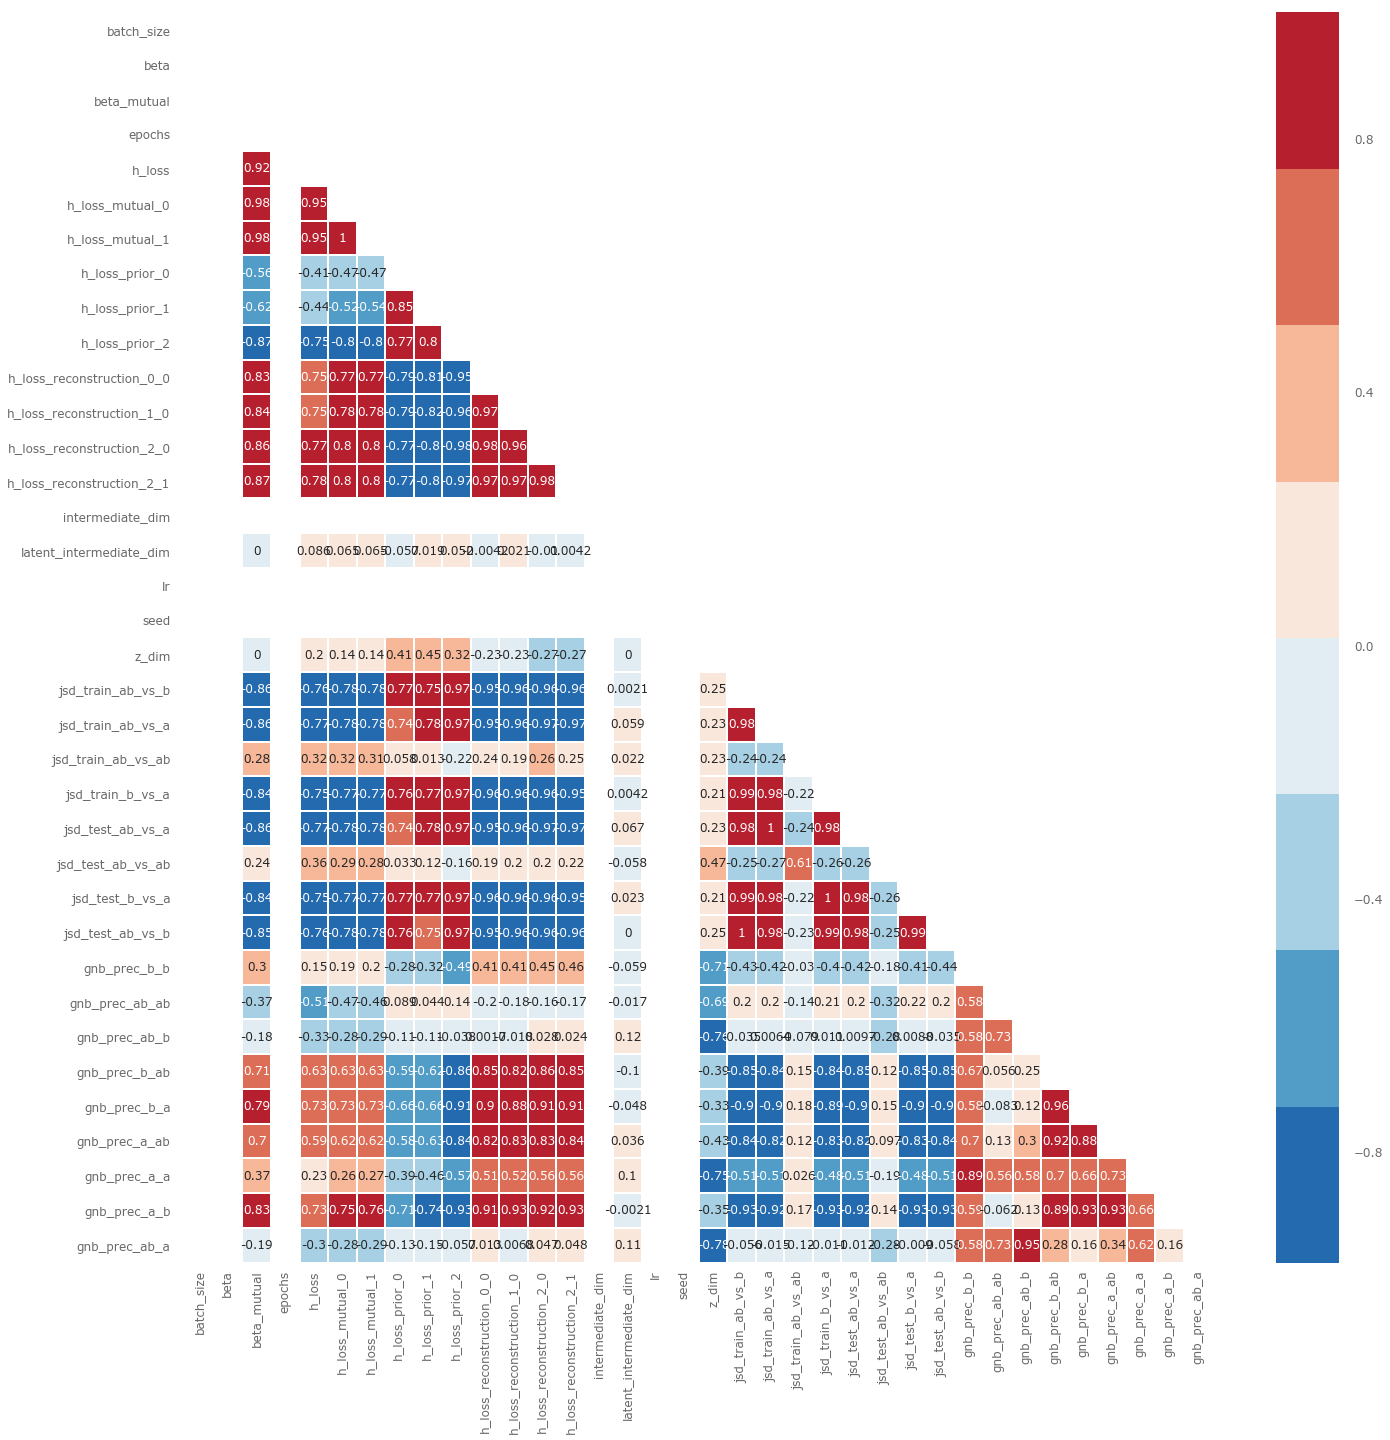

In [16]:
# concat
_df = pd.concat([df, df_jsd, df_gnb], axis =1) # .reset_index()


# make beta-mutual linear
#_df['beta_mutual'] = _df['beta_mutual'].apply(lambda x: int(np.log10(x)))
#_df = _df[_df['beta_mutual'] != int(1)]

# correlation w/o validation
_df = _df.drop(["activation","reconstruction_loss_metrics","optimizer","index"], axis=1)
_df = _df[[c for c in _df.columns if c[:5] != 'h_val']]


astetik.corr(_df, color_grades=5, style='astetik', annot=True)
#_df

In [17]:

#df

_df1 = _df[_df['beta_mutual'] == int(1)]
_df1[['h_loss', 'jsd_test_ab_vs_b']]

,h_loss,jsd_test_ab_vs_b
3,190.934553,0.796827
8,192.952329,0.857046
13,193.377639,0.839269
18,190.837246,0.803505
23,192.579043,0.854365
28,192.863775,0.837943
33,190.788965,0.803730
38,192.081229,0.861457
43,192.241929,0.844074
48,190.568160,0.799952


In [18]:
_df_1 = _df[_df['beta_mutual'] == int(-1)]
_df_1[['h_loss', 'jsd_test_ab_vs_b']]


,h_loss,jsd_test_ab_vs_b


In [19]:
def plot_loss_surface(loss_str = '', hp_str = [''], df = None, axs = None, ngridx = 100, ngridy = 200, vmin=0., vmax=1., norm=None):
    import itertools
    import matplotlib.tri as tri
    #  Plot surfaces in one row
    df_loss = df[[loss_str] + hp_str]
    #df_loss = _df[['h_loss', 'beta_mutual']]
    #_df[_df['beta_mutual'] == int(1)]

    hp_str_pairs = list(itertools.combinations(hp_str, 2))

    print(hp_str_pairs)

    cs = []

    _vmin, _vmax = df_loss[loss_str].values.min(), df_loss[loss_str].values.max()
    for pair, ax in zip(hp_str_pairs, axs):

        z = df_loss[loss_str].values
        x = df_loss[pair[0]].values
        y = df_loss[pair[1]].values

        # Create grid values first.
        xi = np.linspace(x.min(), x.max(), ngridx)
        yi = np.linspace(y.min(), y.max(), ngridy)
        triang = tri.Triangulation(x, y)
        interpolator = tri.LinearTriInterpolator(triang, z)
        Xi, Yi = np.meshgrid(xi, yi)
        zi = interpolator(Xi, Yi)

        #from matplotlib import cm
        #from matplotlib.colors import ListedColormap, LinearSegmentedColormap
        #viridis = cm.get_cmap('viridis', 256)

        #
        #newcolors = viridis(np.linspace(0., 1., 256))
        #newcmp = ListedColormap(newcolors)

        cs.append(ax.pcolor(Xi,Yi,zi, vmin=vmin, vmax=vmax, norm=norm))

        #cs[-1].set_clim(vmin=vmin, vmax=vmax)
        ax.set_ylabel(pair[1])
        ax.set_xlabel(pair[0])

    return cs

In [20]:
# Prepare the data frame
df_plt = _df.copy()
df_plt['latent_intermediate_dim'].replace([None], 0, inplace=True)
df_plt['beta_mutual'] = df_plt['beta_mutual'].apply(lambda x: np.log10(x))

[('beta_mutual', 'latent_intermediate_dim'), ('beta_mutual', 'z_dim'), ('latent_intermediate_dim', 'z_dim')]


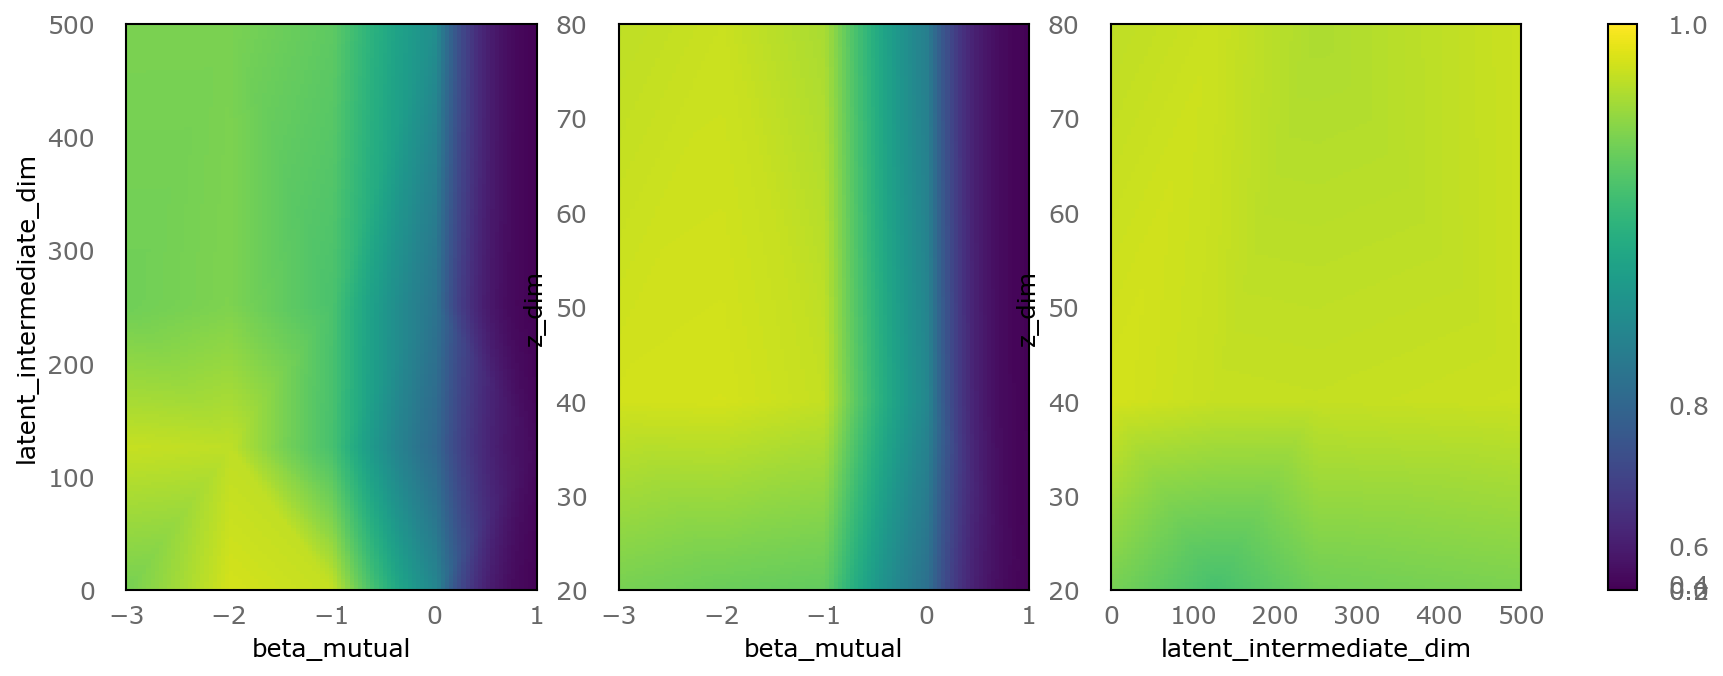

In [21]:
import matplotlib.colors as colors

f, ax = plt.subplots(1,3, figsize = (15, 5), dpi = 150)
# vmin, vmax = df_loss[loss_str].values.min(), df_loss[loss_str].values.max()
cs = plot_loss_surface('jsd_test_ab_vs_a', ['beta_mutual', 'latent_intermediate_dim', 'z_dim'],
                       df_plt, ax, vmin=0., vmax=1., norm=colors.PowerNorm(gamma=5.))
#f.colorbar(cs[-1], ax=ax[-1], shrink=0.9)
#f.set_clim(0., 1.)
f.colorbar(cs[-1], ax=ax)
print(cs[-1])
#f.colorbar()
plt.show()


In [22]:
x, y, Z = df['beta_mutual'].values, df['latent_intermediate_dim'].values, df['h_loss'].values
x = x[np.newaxis, :]
y = y[:, np.newaxis]

In [26]:
import plotly.express as px
fig = px.parallel_coordinates(df_plt, color="jsd_test_ab_vs_a",
                              dimensions=['latent_intermediate_dim', 'z_dim', 'beta_mutual'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)
fig.show()


In [44]:

fig = px.parallel_coordinates(df_plt, color="z_dim",
                              dimensions=['h_loss', 'jsd_test_ab_vs_a', 'h_loss_mutual_0', 'h_loss_mutual_1'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=50)
fig.show()

In [ ]:
fig = px.parallel_coordinates(df_plt, color="latent_intermediate_dim",
                              dimensions=['h_loss', 'jsd_test_ab_vs_a', 'h_loss_mutual_0', 'h_loss_mutual_1'],
                              color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

In [50]:
fig = px.parallel_coordinates(df_plt, color="beta_mutual",
                              dimensions=['h_loss', 'h_loss_mutual_0', 'h_loss_mutual_1', 'gnb_prec_ab_a', 'jsd_test_ab_vs_a'],
                              color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()


In [80]:
fig = px.parallel_coordinates(df_plt, color="beta_mutual",
                              dimensions=['z_dim', 'latent_intermediate_dim', 'gnb_prec_ab_a', 'jsd_test_ab_vs_a'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              width=1920/2, height=1080/2)
fig.show()


# End of File